In [1]:
#undersample
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule

#oversample
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

#over+under
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

#models
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier



#utils
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

#metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import fbeta_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import f1_score

## Read and understand data

In [2]:
data = pd.read_csv('creditcard.csv')
print(data.shape)
data.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Load the data and reduce the memory usage of each dataframe

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [4]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 67.36 MB
Memory usage after optimization is: 17.11 MB
Decreased by 74.6%


In [5]:
data.dtypes

Time      float32
V1        float16
V2        float16
V3        float16
V4        float16
V5        float16
V6        float16
V7        float16
V8        float16
V9        float16
V10       float16
V11       float16
V12       float16
V13       float16
V14       float16
V15       float16
V16       float16
V17       float16
V18       float16
V19       float16
V20       float16
V21       float16
V22       float16
V23       float16
V24       float16
V25       float16
V26       float16
V27       float16
V28       float16
Amount    float16
Class        int8
dtype: object

In [6]:
object_types = data.select_dtypes(include=['object','category'])
object_types.columns

Index([], dtype='object')

## Statistical Summary

In [7]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,...,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94812.664062,-0.000062,0.000028,NaN,0.000053,0.000163,-0.000033,0.000001,-0.000022,-0.000013,...,0.000008,-0.000054,0.000011,0.000004,0.000068,-0.000007,-7.152557e-07,2.384186e-07,NaN,0.001727
std,47487.195312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.035645e-01,3.300781e-01,NaN,0.041527
min,0.000000,-56.406250,-72.687500,-48.312500,-5.683594,-113.750000,-26.156250,-43.562500,-73.187500,-13.437500,...,-34.843750,-10.929688,-44.812500,-2.835938,-10.296875,-2.605469,-2.256250e+01,-1.542969e+01,0.000000,0.000000
25%,54201.500000,-0.920410,-0.598633,-0.890137,-0.848633,-0.691406,-0.768066,-0.554199,-0.208618,-0.643066,...,-0.228394,-0.542480,-0.161865,-0.354492,-0.317139,-0.326904,-7.086182e-02,-5.294800e-02,5.601562,0.000000
50%,84692.000000,0.018112,0.065491,0.179810,-0.019852,-0.054321,-0.274170,0.040100,0.022354,-0.051422,...,-0.029449,0.006783,-0.011192,0.040985,0.016586,-0.052124,1.341820e-03,1.124573e-02,22.000000,0.000000
75%,139320.500000,1.315430,0.803711,1.027344,0.743164,0.611816,0.398682,0.570312,0.327393,0.597168,...,0.186401,0.528320,0.147583,0.439453,0.350830,0.240967,9.106445e-02,7.830811e-02,77.187500,0.000000
max,172792.000000,2.455078,22.062500,9.382812,16.875000,34.812500,73.312500,120.562500,20.000000,15.593750,...,27.203125,10.500000,22.531250,4.585938,7.519531,3.517578,3.160938e+01,3.384375e+01,25696.000000,1.000000


### Summarizing the number of unique values in each column


In [8]:
print(data.nunique())

Time      124592
V1         17239
V2         21462
V3         18221
V4         18661
V5         20454
V6         19734
V7         21084
V8         23301
V9         19442
V10        21042
V11        17517
V12        19264
V13        18406
V14        20199
V15        18066
V16        18899
V17        19236
V18        18716
V19        19281
V20        22820
V21        22264
V22        18352
V23        22698
V24        19392
V25        18426
V26        17050
V27        23887
V28        23023
Amount      8976
Class          2
dtype: int64


### Columns with  single value

Columns that have a single value are probably useless for modeling. These
columns are referred to zero-variance predictors, so we dont need to use them anymore.

In [9]:
values = data.nunique()
single_value_cols = [values.index[i] for i,v in enumerate(values) if v == 1]
single_value_cols

[]

### Checking duplicate rows

Duplicate row is a row where each value in each column for that row appears in identically the same column values in another row.  They are could be useless to the modeling process. 

duplicated() function will report whether a given row is duplicated or not. All
rows are marked as either False to indicate that it is not a duplicate or True to indicate that
it is a duplicate.

In [10]:
dups = data.duplicated()
print(dups.any())

True


In [11]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [12]:
data.drop_duplicates(inplace=True)
print(data.shape)

(283726, 31)


In [13]:
data['Class'].value_counts()

0    283253
1       473
Name: Class, dtype: int64

# Explotary Data Analysis

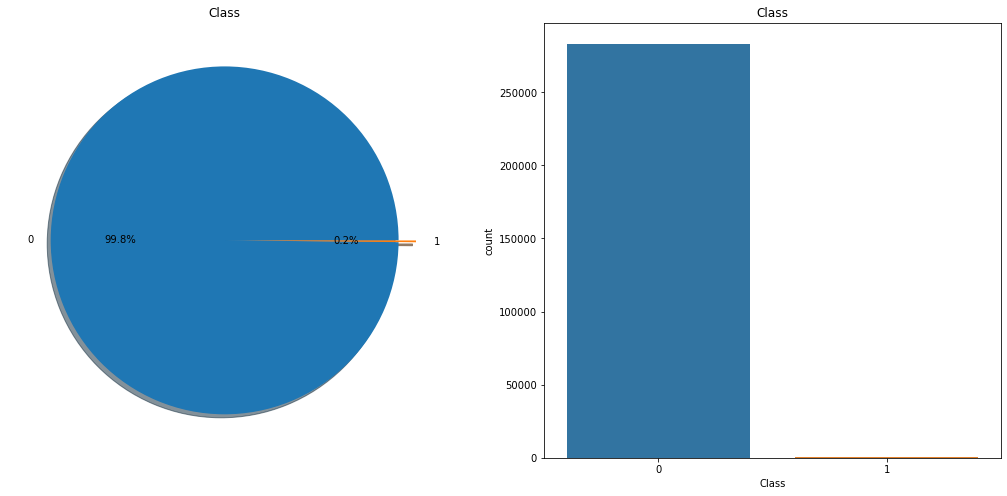

In [14]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Class'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Class')
ax[0].set_ylabel('')
sns.countplot('Class',data=data,ax=ax[1])
ax[1].set_title('Class')
plt.show()

The graphs show that our dataset is highly imbalanced.

First let us understand the different types of features.

# Distribution  of anomaly and normal  data

In [15]:
def plot_histogram(df, bins, column, log_scale=False):
    bins = 100
    anomalies = df[df.Class == 1]
    normal = df[df.Class == 0]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    fig.suptitle(f'Counts of {column} by Class')
    ax1.hist(anomalies[column], bins = bins, color="red")
    ax1.set_title('Anomaly')
    ax2.hist(normal[column], bins = bins, color="orange")
    ax2.set_title('Normal')
    plt.xlabel(f'{column}')
    plt.ylabel('Count')
    if log_scale:
        plt.yscale('log')
    plt.xlim((np.min(df[column]), np.max(df[column])))
    plt.show()

A histogram of data for the column V12 in df. As we
can see, there is a very clear deviation seen with the anomalous values
compared to the normal values. Both plots share the same x-axis
scale, so while the counts might be very low compared to the normal
values, they are still spread out far more than the normal values for
the same range of V12 column values.

V1 Counts


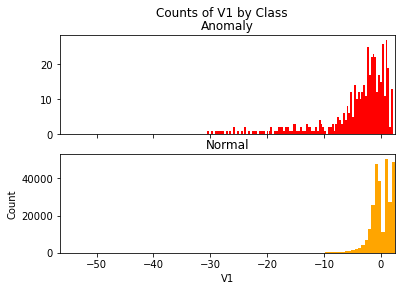

V2 Counts


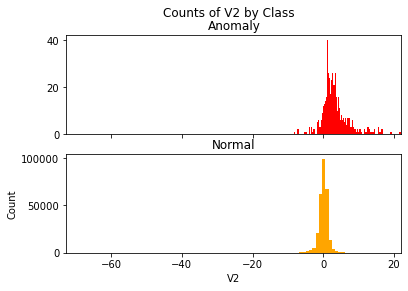

V3 Counts


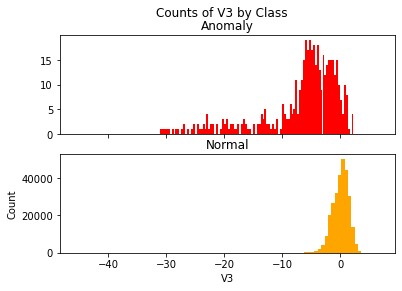

V4 Counts


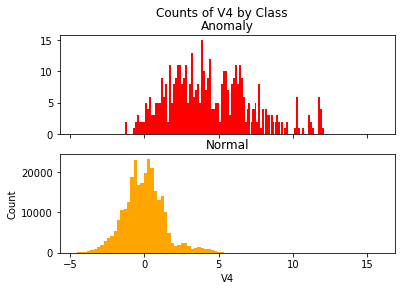

V5 Counts


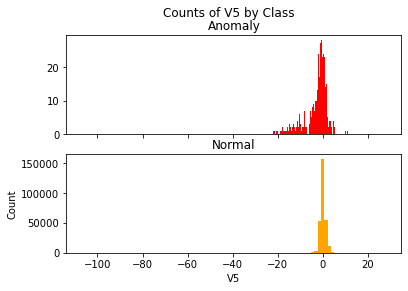

V6 Counts


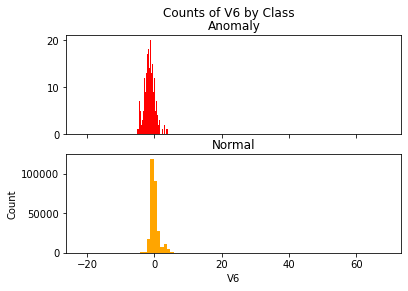

V7 Counts


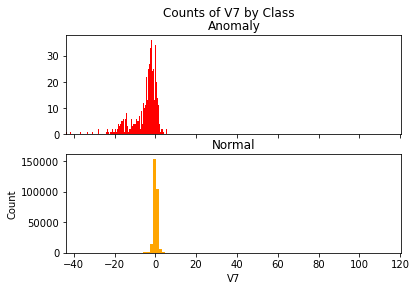

V8 Counts


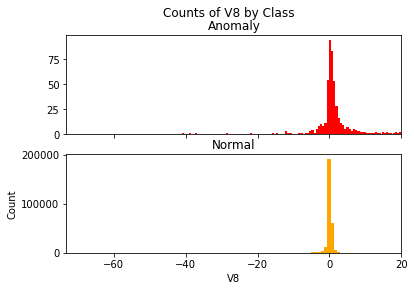

V9 Counts


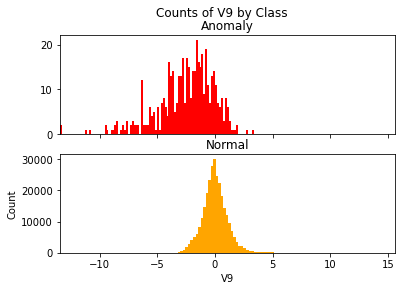

V10 Counts


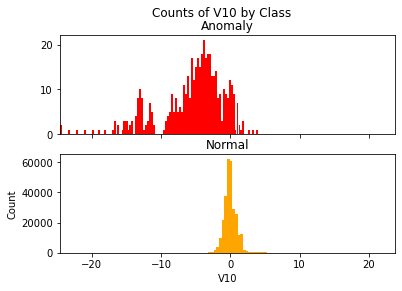

V11 Counts


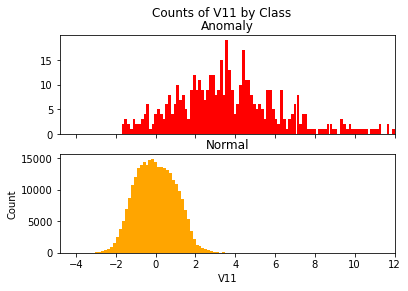

V12 Counts


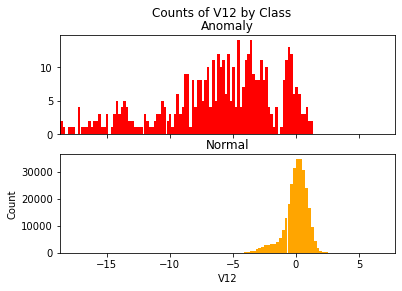

V13 Counts


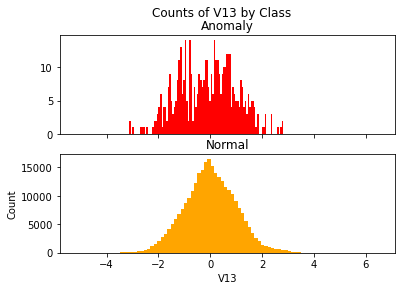

V14 Counts


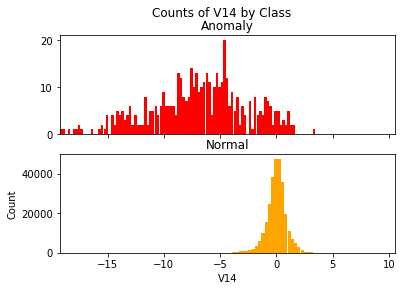

V15 Counts


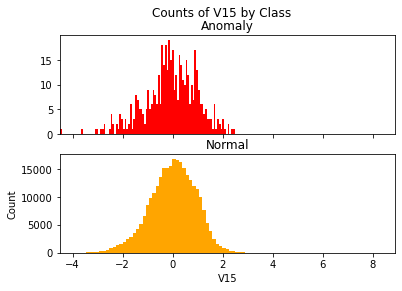

V16 Counts


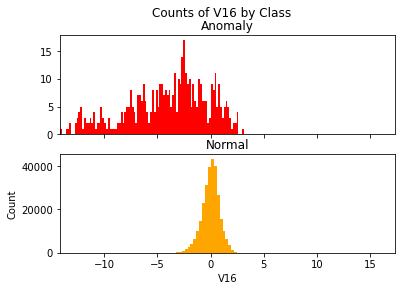

V17 Counts


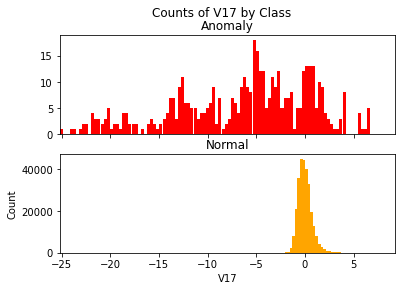

V18 Counts


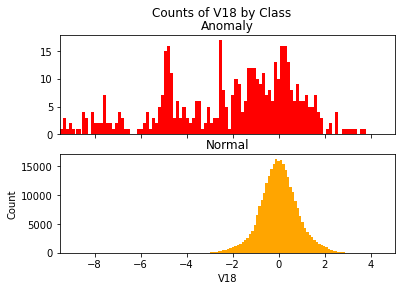

V19 Counts


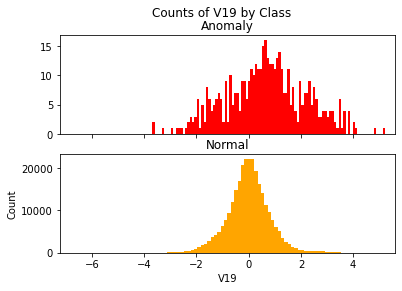

V20 Counts


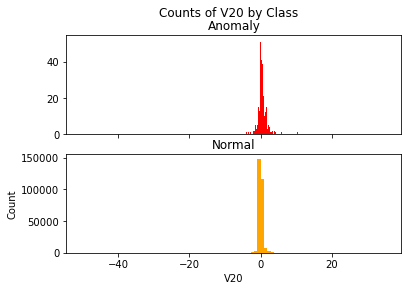

V21 Counts


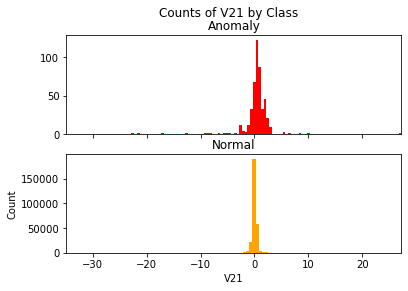

V22 Counts


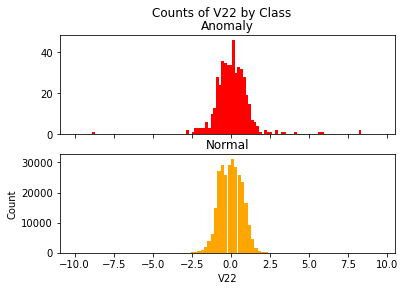

V23 Counts


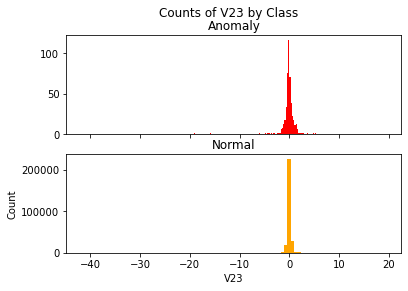

V24 Counts


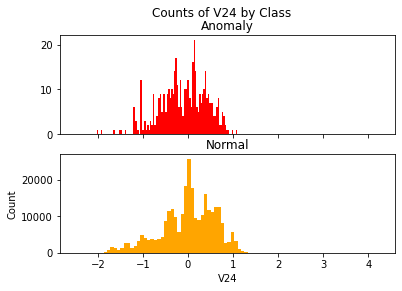

V25 Counts


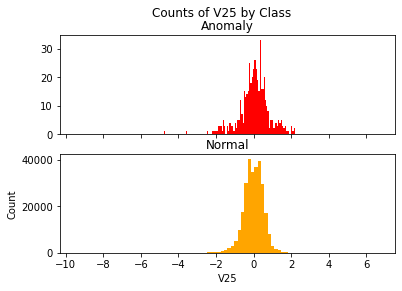

V26 Counts


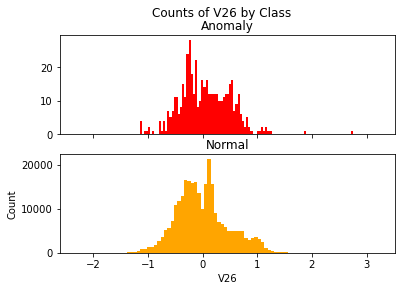

V27 Counts


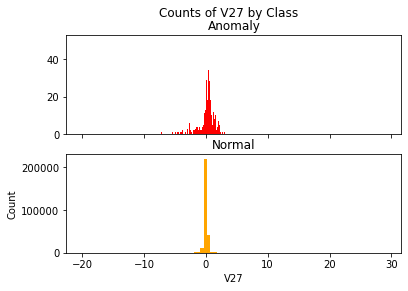

V28 Counts


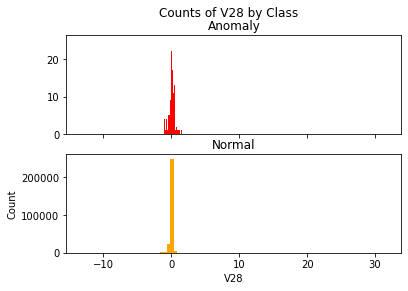

In [16]:
for f in range(1, 29):
    print(f'V{f} Counts')
    plot_histogram(data,100, f'V{f}')

#### From this, you can definitely notice a right skew as well as the massive outliers present in the normal data.

#### Other than a few defined spikes that stand out from where the normal points would have been, most of the fraudulent data in this context seems to blend in with the normal data.

### Distrubiton of all numeric features

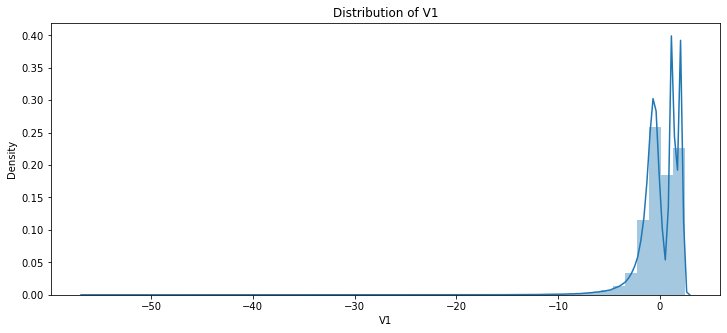

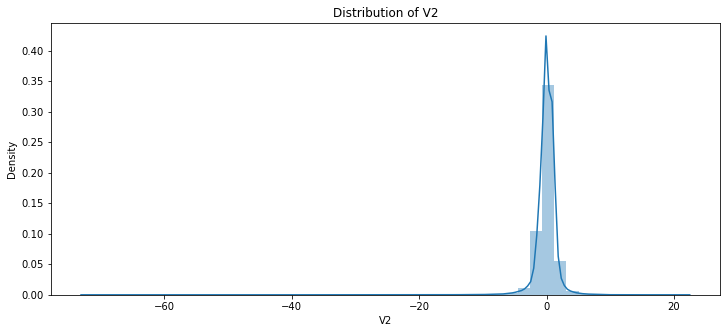

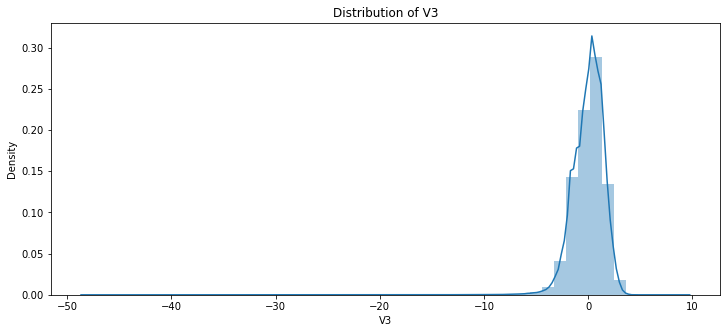

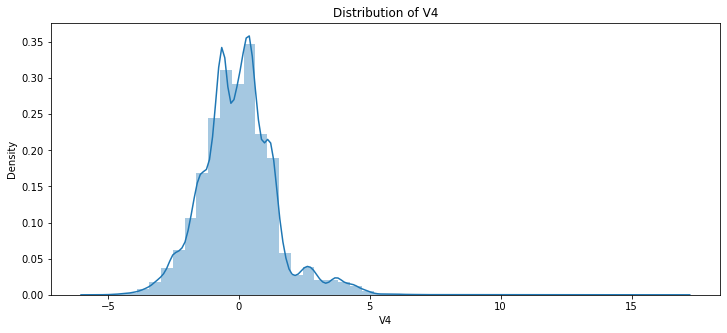

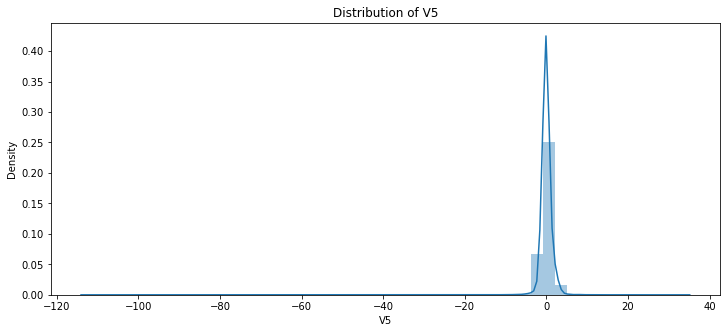

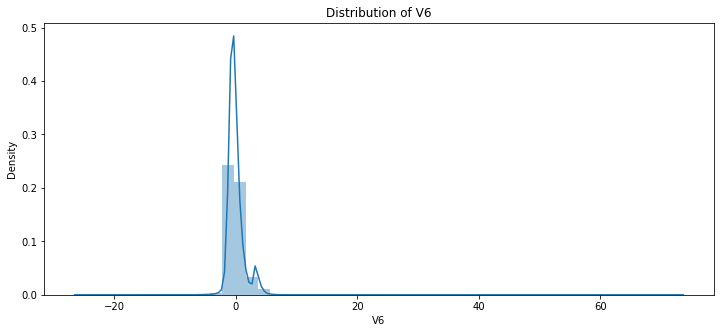

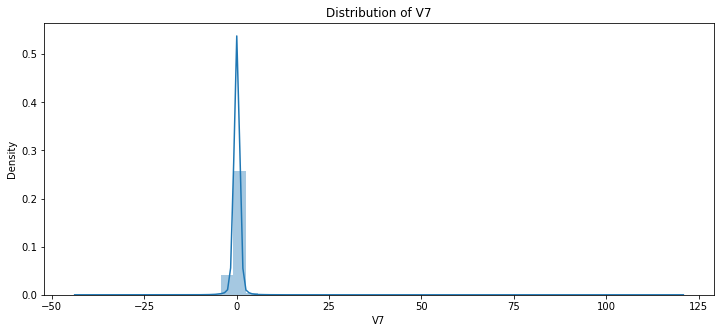

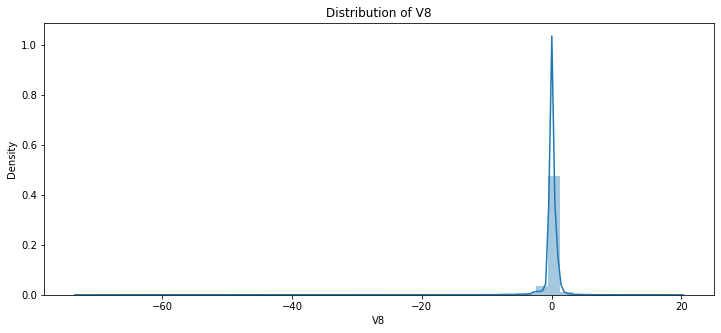

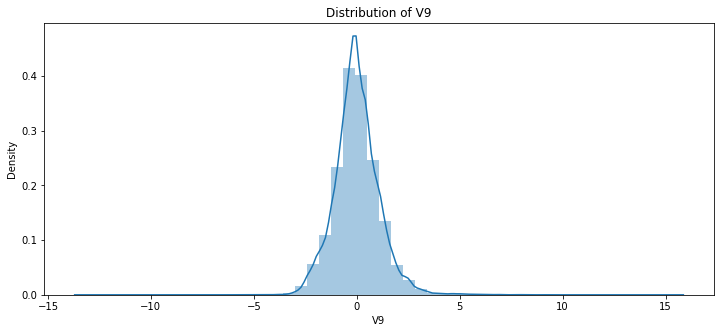

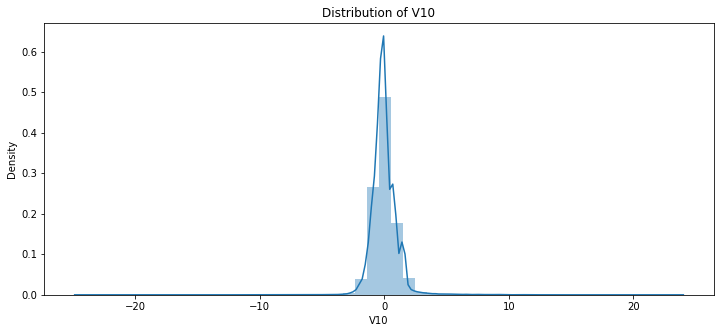

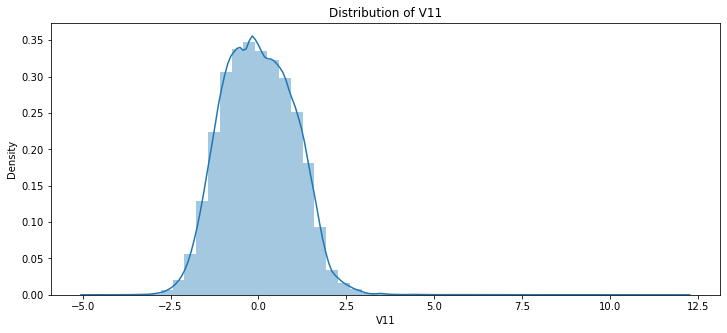

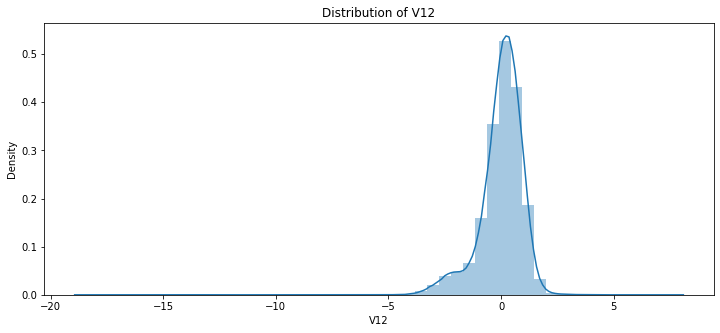

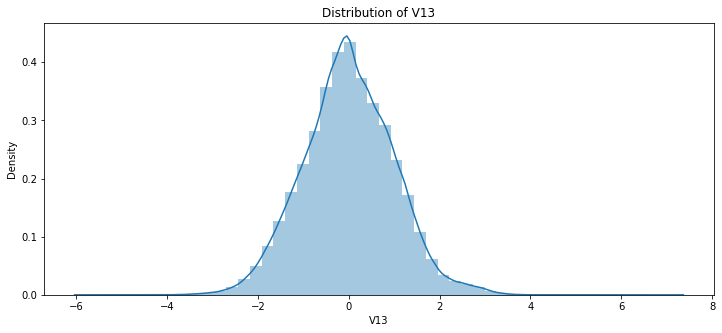

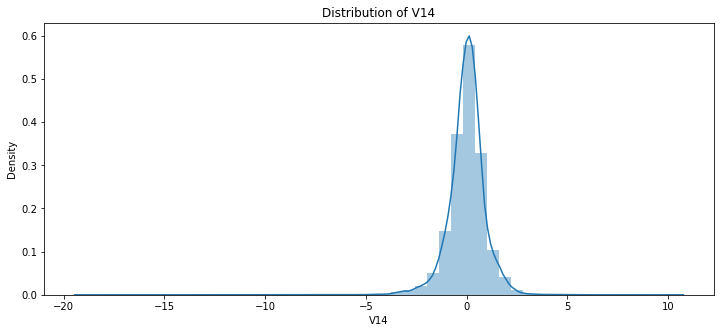

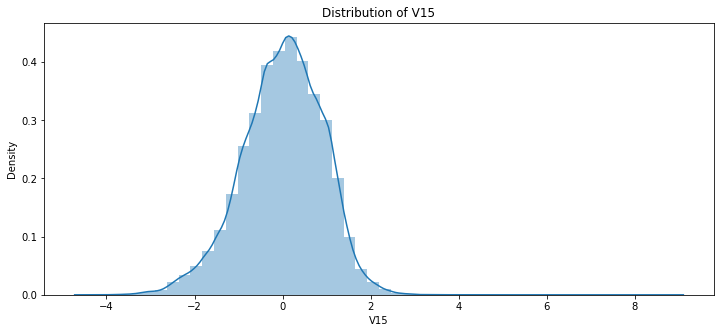

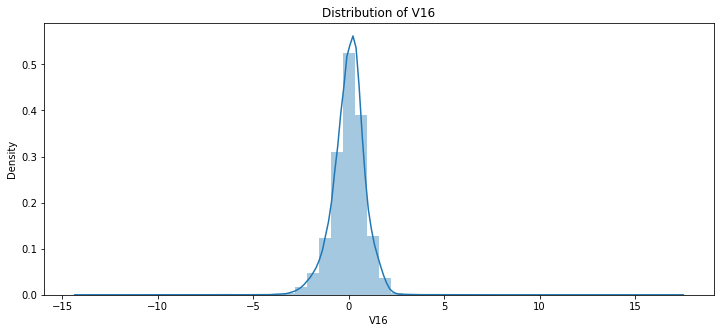

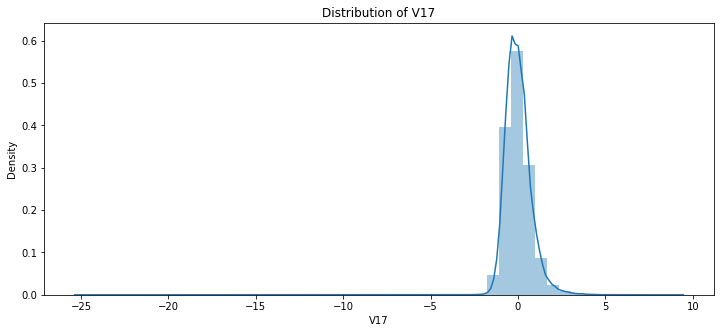

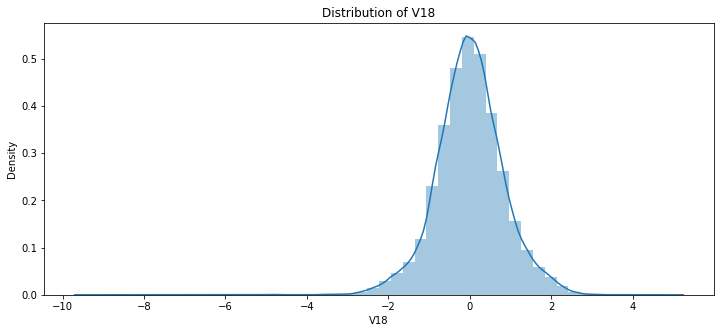

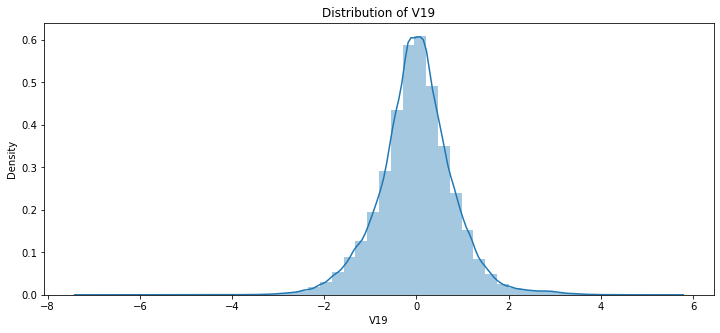

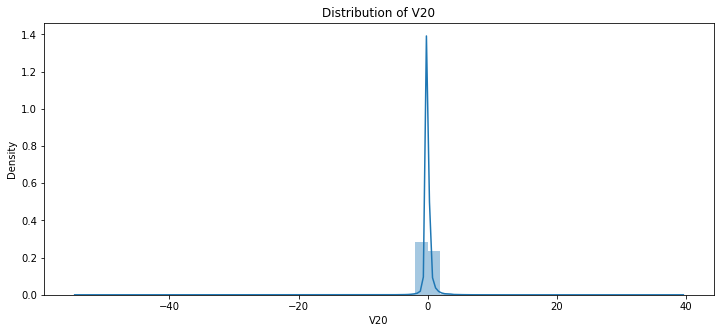

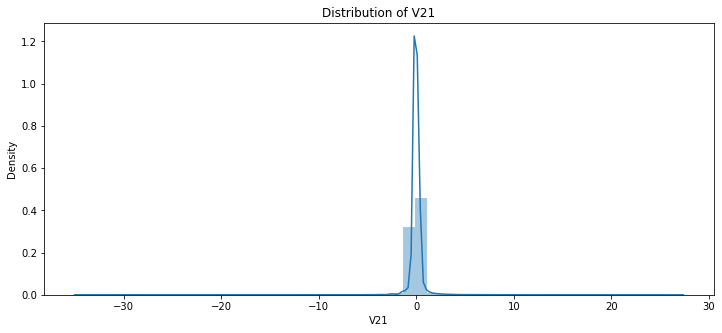

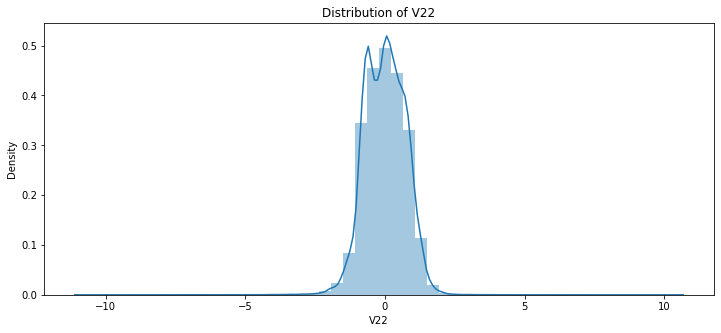

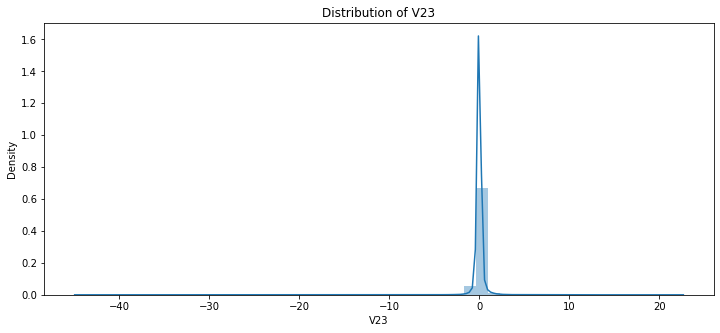

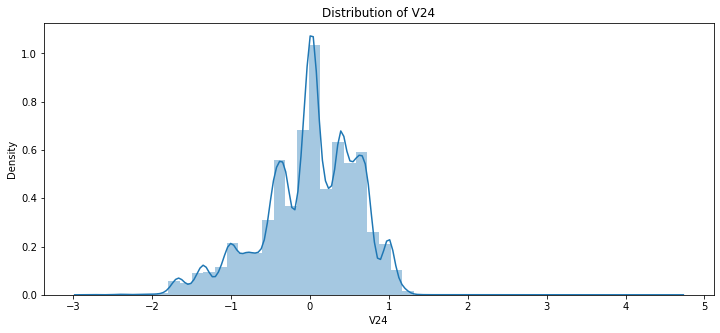

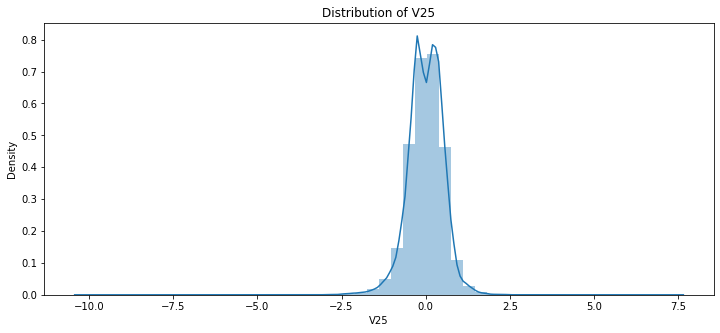

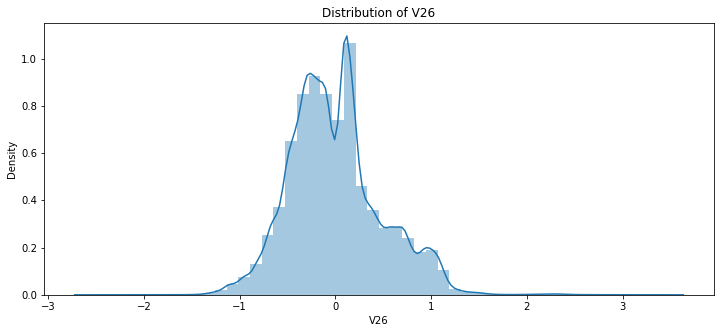

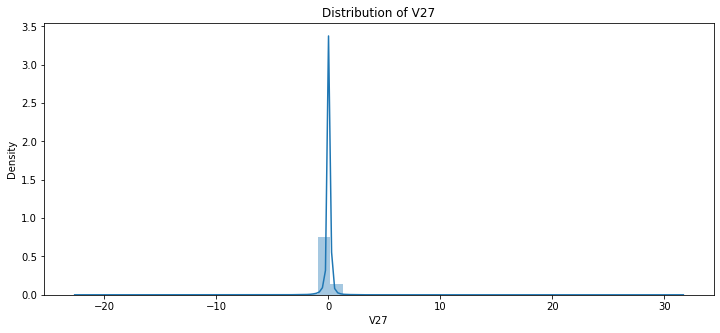

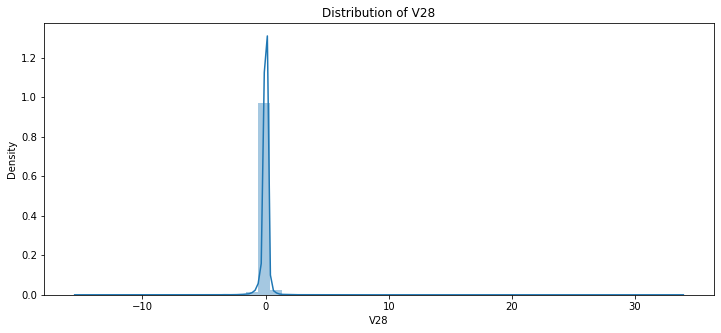

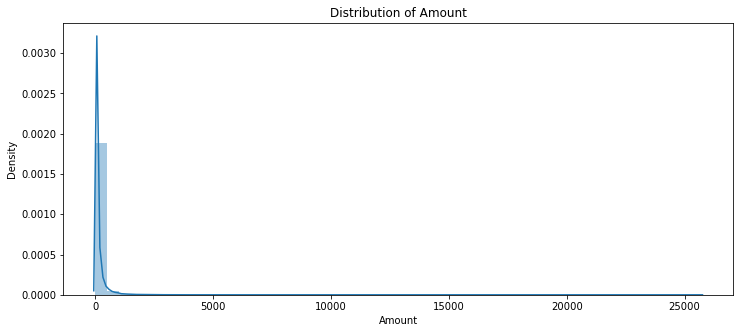

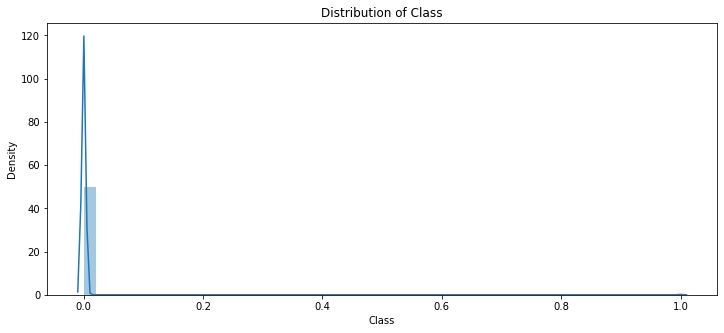

In [17]:
numeric = data.select_dtypes(include = 'number')
for col in list(numeric)[1:]:
    plt.figure(figsize=(12,5))
    plt.title(f"Distribution of {col}")
    ax = sns.distplot(data[col])
    plt.show()

As we see, we have huge amount of outliers which have to be handled before modeling.

# Data Splitting

In [18]:
def load_data(data_path):
    data = pd.read_csv(data_path)
    data = reduce_mem_usage(data)
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    
    X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.3, shuffle = True)
    
    return X_train,X_test,Y_train,Y_test

X_train,X_test,Y_train,Y_test = load_data('creditcard.csv')

Memory usage of dataframe is 67.36 MB
Memory usage after optimization is: 17.11 MB
Decreased by 74.6%


# Evaluation

Firstly, because most of the standard
metrics that are widely used assume a balanced class distribution, and because typically not
all classes, and therefore, not all prediction errors, are equal for imbalanced classification. So, accuracy is inappropriate for
imbalanced classification problems. 

The main reason is that the overwhelming number of
examples from the majority class (or classes) will overwhelm the number of examples in the
minority class, meaning that even unskillful models can achieve accuracy scores of 90 percent,
or 99 percent, depending on how severe the class imbalance happens to be. 

As a evaluation metric I am using __balanced_accuracy_score, roc_auc_score, geometric_mean_score.__

In [19]:
def evaluate_model(ytrue, ypred):
    metrics = {}
    metrics['balanced_accuracy_score']=balanced_accuracy_score(ytrue, ypred)
    metrics['roc_auc_score'] = roc_auc_score(ytrue, ypred)
    metrics['geometric_mean_score'] = geometric_mean_score(ytrue, ypred)
    return metrics

# Trying different approaches

 In
this project, I have discovered metrics that we can use for imbalanced classification. Beside of this, I have used different approaches:


## 1. Data Sampling Methods

Data sampling provides a collection of techniques that transform a training dataset in
order to balance or better balance the class distribution. lthough often described in terms of two-class classification problems, class imbalance also
affects those datasets with more than two classes that may have multiple minority classes
or multiple majority classes. __Oversampling methods duplicate examples in the minority class or synthesize new examples
from the examples in the minority class. Meanwhile, Undersampling methods delete or select a subset of examples from the majority class.__ 

### 1.1 SMOTE (Synthetic Minority Oversampling Technique)

SMOTE first selects a minority class instance a at random and finds its k nearest
minority class neighbors. The synthetic instance is then created by choosing one of
the k nearest neighbors b at random and connecting a and b to form a line segment
in the feature space. The synthetic instances are generated as a convex combination
of the two chosen instances a and b.

### 1.2  ADASYN (Adaptive Synthetic Sampling)

It is a modification of SMOTE that is based on the idea of adaptively generating minority data samples
according to their distributions: more synthetic data is generated for minority class
samples that are harder to learn compared to those minority samples that are easier
to learn.


### 1.3 Borderline-SMOTE

A popular extension to SMOTE involves selecting those instances of the minority class that are
misclassified, such as with a k-nearest neighbor classification model. We can then oversample
just those difficult instances, providing more resolution only where it may be required.


### 1.4 SVM-SMOTE

This method is an alternative to Borderline-SMOTE where a SVM algorithm
is used instead of a KNN to identify misclassified examples on the decision boundary. In the SVMSMOTE(), borderline area is approximated by the support vectors obtained after training
a standard SVMs classifier on the original training set. New instances will be
randomly created along the lines joining each minority class support vector with a
number of its nearest neighbors using the interpolation


### 1.5 Near Miss Undersampling

In this method, we have three versions of
the technique, named NearMiss-1, NearMiss-2, and NearMiss-3. 

Here, distance is determined in feature space
using Euclidean distance or similar.

 NearMiss-1: Majority class examples with minimum average distance to three closest
minority class examples.

 NearMiss-2: Majority class examples with minimum average distance to three furthest
minority class examples.

 NearMiss-3: Majority class examples with minimum distance to each minority class
example.



In [20]:
names = [SMOTE(),NearMiss(),BorderlineSMOTE(),SVMSMOTE(),ADASYN()]
names

[SMOTE(), NearMiss(), BorderlineSMOTE(), SVMSMOTE(), ADASYN()]

In [21]:
def sampling_method(method_name,xtrain,ytrain):
    resample = method_name
    model = LogisticRegression()
    X_train_res,Y_train_res=resample.fit_resample(xtrain,ytrain)
    start_time = time.time()
    print(X_train_res.shape,Y_train_res.shape)
    model.fit(X_train_res,Y_train_res)
    pred = model.predict(X_test)
    
    metrics_dict = evaluate_model(Y_test, pred)
    metrics_dict['model_name'] = str(model)
    metrics_dict['resample_method'] = str(resample)
    metrics_dict['train_time']= time.time() - start_time
    return metrics_dict

In [22]:
resample_results = []
for i in tqdm(names):
    result = sampling_method(i,X_train,Y_train)
    resample_results.append(result)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

(398010, 30) (398010,)


 40%|█████████████████████████████████▌                                                  | 2/5 [00:06<00:09,  3.29s/it]

(718, 30) (718,)
(398010, 30) (398010,)


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:16<00:11,  6.00s/it]

(398010, 30) (398010,)


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:35<00:11, 11.35s/it]

(397989, 30) (397989,)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.85s/it]


# Probalistic models

Probabilistic models are
those models that are fit on the data under a probabilistic framework and often perform well
in general for imbalanced classification dataset. I will evaluate a suite of models that are known to be effective at predicting probabilities.

Specifically, these are models that are fit under a probabilistic framework and explicitly predict a
calibrated probability for each example. A such, this makes them well-suited to this dataset, even
with the class imbalance. We will evaluate the following six probabilistic models implemented
with the scikit-learn library:

#### Logistic Regression (LR)
#### Linear Discriminant Analysis (LDA)
#### Quadratic Discriminant Analysis (QDA)
#### Gaussian Naive Bayes (GNB)
#### Gaussian Process (GPC)

In [23]:
prob_models = [LinearDiscriminantAnalysis(), LogisticRegression(solver='lbfgs'), QuadraticDiscriminantAnalysis(), GaussianNB(), GaussianProcessClassifier()]

In [24]:
def prob_method(model_name,xtrain,ytrain):
    model = model_name
    start_time = time.time()
    print(xtrain.shape,ytrain.shape)
    model.fit(xtrain, ytrain)
    pred = model.predict(X_test)
    
    metrics_dict = evaluate_model(Y_test, pred)
    metrics_dict['model_name'] = str(model)
    metrics_dict['resample_method'] = 'Probalistic'
    metrics_dict['train_time']= time.time() - start_time
    return metrics_dict

In [25]:
prob_results = []

for i in tqdm(prob_models):
    result = prob_method(i, X_train, Y_train)
    prob_results.append(result)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

(199364, 30) (199364,)


 20%|████████████████▊                                                                   | 1/5 [00:01<00:05,  1.26s/it]

(199364, 30) (199364,)


 40%|█████████████████████████████████▌                                                  | 2/5 [00:04<00:06,  2.32s/it]

(199364, 30) (199364,)


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:04<00:03,  1.55s/it]

(199364, 30) (199364,)


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:05<00:01,  1.30s/it]


(199364, 30) (199364,)


MemoryError: Unable to allocate 296. GiB for an array with shape (199364, 199364) and data type float64

# Cost sensitive models

Some machine learning algorithms can be adapted to pay more attention to one class than
another when fitting the model. These are referred to as cost-sensitive machine learning
models and they can be used for imbalanced classification by specifying a cost that is inversely
proportional to the class distribution.

Cost-sensitive learning is a subfield of machine learning that takes the costs of prediction
errors (and potentially other costs) into account when training a machine learning model. It is
a field of study that is closely related to the field of imbalanced learning that is concerned with
classification on datasets with a skewed class distribution.

In [26]:
cost_sens_models = [LogisticRegression(solver='lbfgs', class_weight='balanced'), DecisionTreeClassifier(class_weight='balanced')]

In [27]:
def cost_method(model_name,xtrain,ytrain):
    model = model_name
    start_time = time.time()
    print(xtrain.shape,ytrain.shape)
    model.fit(xtrain, ytrain)
    pred = model.predict(X_test)
    
    metrics_dict = evaluate_model(Y_test, pred)
    metrics_dict['model_name'] = str(model)
    metrics_dict['resample_method'] = 'Cost Sensitive'
    metrics_dict['train_time']= time.time() - start_time
    return metrics_dict

In [28]:
cost_results = []

for i in tqdm(cost_sens_models):
    result = cost_method(i, X_train, Y_train)
    cost_results.append(result)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

(199364, 30) (199364,)


 50%|██████████████████████████████████████████                                          | 1/2 [00:02<00:02,  2.14s/it]

(199364, 30) (199364,)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]


In [29]:
results = resample_results + prob_results + cost_results

In [30]:
final = pd.DataFrame(results)
final

,balanced_accuracy_score,roc_auc_score,geometric_mean_score,model_name,resample_method,train_time
0,0.944209,0.944209,0.943580,LogisticRegression(),SMOTE(),4.317860
1,0.919391,0.919391,0.919164,LogisticRegression(),NearMiss(),0.103993
2,0.921571,0.921571,0.918758,LogisticRegression(),BorderlineSMOTE(),6.696936
3,0.900204,0.900204,0.895104,LogisticRegression(),SVMSMOTE(),6.418762
4,0.947423,0.947423,0.946944,LogisticRegression(),ADASYN(),5.911775
5,0.894631,0.894631,0.888430,LinearDiscriminantAnalysis(),Probalistic,1.255213
6,0.845642,0.845642,0.831517,LogisticRegression(),Probalistic,3.064365
7,0.927653,0.927653,0.926413,QuadraticDiscriminantAnalysis(),Probalistic,0.636947
8,0.831328,0.831328,0.815360,GaussianNB(),Probalistic,0.204037
9,0.939493,0.939493,0.939231,LogisticRegression(class_weight='balanced'),Cost Sensitive,2.141368


In [31]:
final.sort_values(by = 'balanced_accuracy_score', ascending=False)

,balanced_accuracy_score,roc_auc_score,geometric_mean_score,model_name,resample_method,train_time
4,0.947423,0.947423,0.946944,LogisticRegression(),ADASYN(),5.911775
0,0.944209,0.944209,0.943580,LogisticRegression(),SMOTE(),4.317860
9,0.939493,0.939493,0.939231,LogisticRegression(class_weight='balanced'),Cost Sensitive,2.141368
7,0.927653,0.927653,0.926413,QuadraticDiscriminantAnalysis(),Probalistic,0.636947
2,0.921571,0.921571,0.918758,LogisticRegression(),BorderlineSMOTE(),6.696936
1,0.919391,0.919391,0.919164,LogisticRegression(),NearMiss(),0.103993
3,0.900204,0.900204,0.895104,LogisticRegression(),SVMSMOTE(),6.418762
5,0.894631,0.894631,0.888430,LinearDiscriminantAnalysis(),Probalistic,1.255213
10,0.864433,0.864433,0.853809,DecisionTreeClassifier(class_weight='balanced'),Cost Sensitive,3.559726
6,0.845642,0.845642,0.831517,LogisticRegression(),Probalistic,3.064365


# best model is: LogisticRegression() + ADASYN()

We can add new models or combinations as well. Because, a  few approaches were applied.